In [30]:
#Heart Disease Prediction using Logistic Regression
#The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD)

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

In [59]:
# Loading Heart Data from framingham.csv
chd_df=pd.read_csv("framingham.csv")
#drop a column
chd_df.drop(['education'],axis=1,inplace=True)
chd_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [33]:
#Rename 'male' column name
chd_df.rename(columns={'male':'sex_male'},inplace=True)

In [34]:
#Find missing values
chd_df.isnull().sum()

sex_male             0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [35]:
#Counting total no of rows with missing values
count=0
for i in chd_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values =', count)
print('Percentage of rows with missing values in the dataset =',round((count/len(chd_df.index))*100),'%')
print('Therefore, the missing values are eliminated.')

Total number of rows with missing values = 489
Percentage of rows with missing values in the dataset = 12 %
Therefore, the missing values are eliminated.


In [36]:
#dropping the missing values
chd_df.dropna(axis=0,inplace=True)

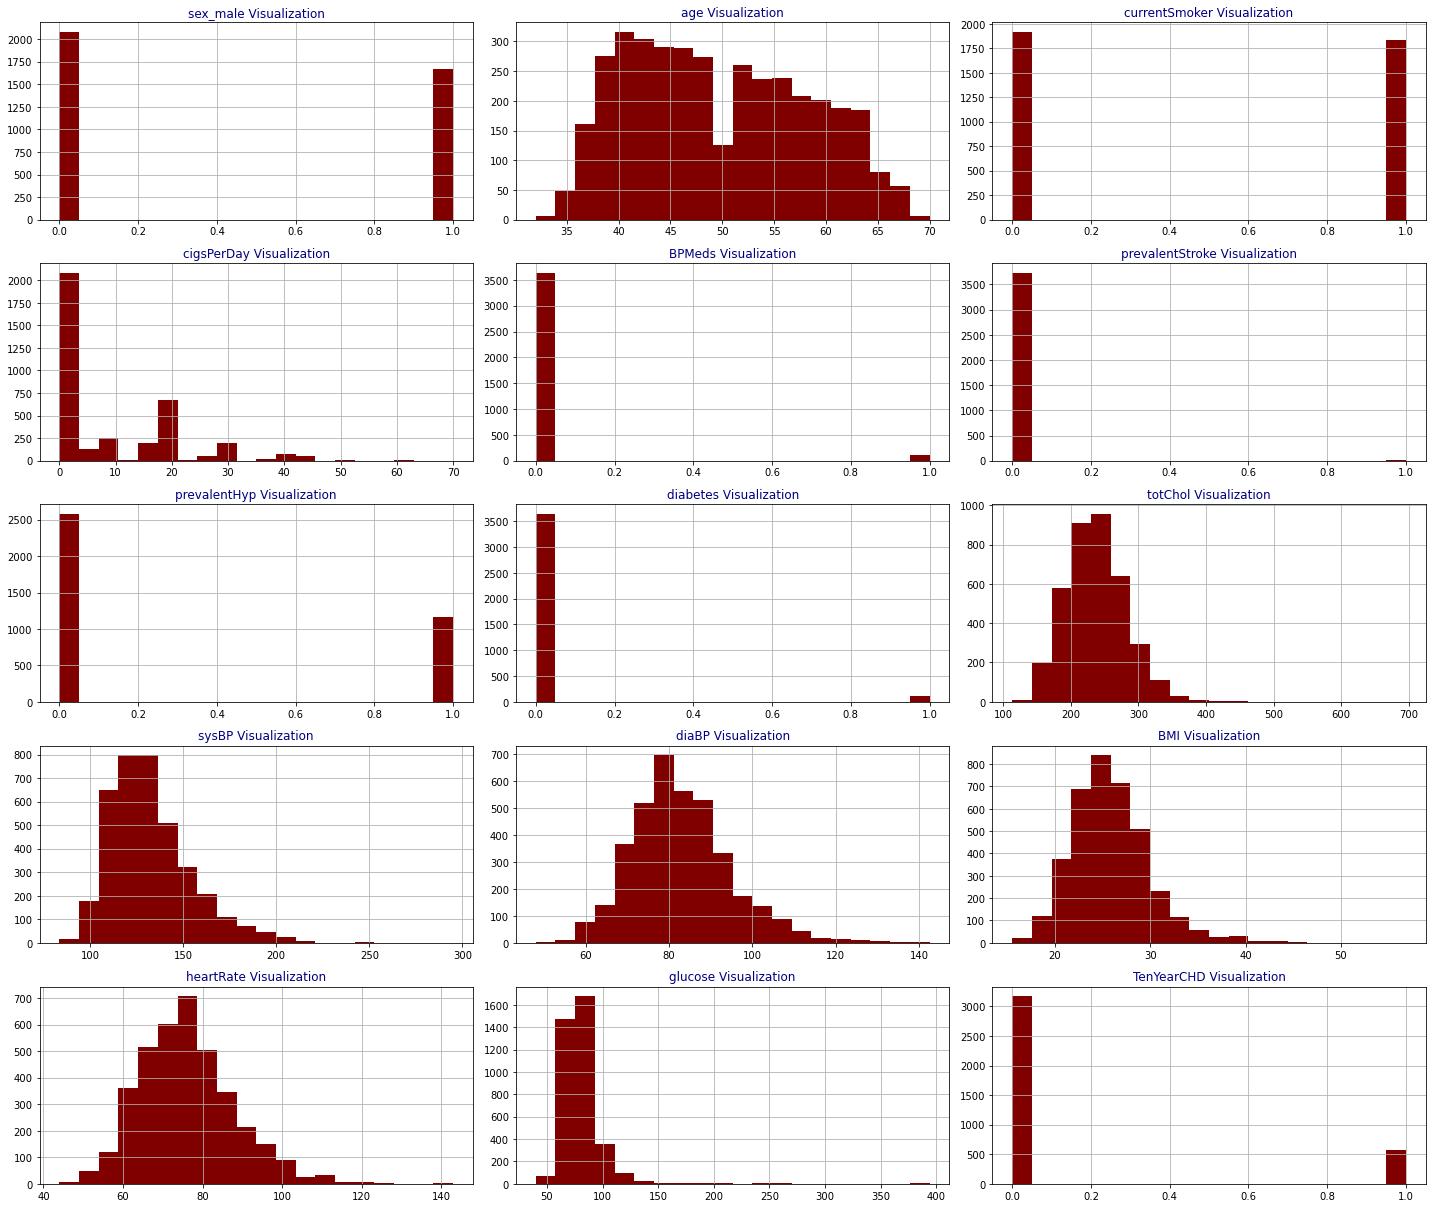

In [37]:
#Exploratory Analysis by drawing histograms for CHD features
def draw_chd_histograms(dataframe, features, rows, cols):
    fig_chd=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax_chd=fig_chd.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax_chd,facecolor='maroon')
        ax_chd.set_title(feature+" Visualization",color='navy')
        
    fig_chd.tight_layout()  
    plt.show()
#Call the histogram function
draw_chd_histograms(chd_df,chd_df.columns,6,3)

In [38]:
#TenYearCHD feature values counting
chd_df.TenYearCHD.value_counts()

0    3177
1     572
Name: TenYearCHD, dtype: int64

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

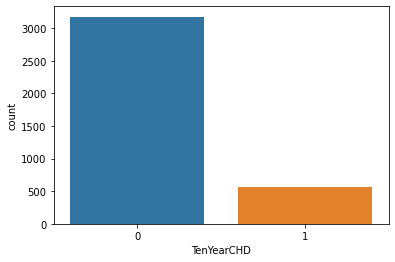

In [39]:
#Plot a graph for the TenYearCHD feature value data 
sn.countplot(x='TenYearCHD',data=chd_df)

In [40]:
print('Therefore, there are',(chd_df.TenYearCHD == 1).sum(),'patients with risk of heart disease and',(chd_df.TenYearCHD == 0).sum(),'patents with no heart disease.')

Therefore, there are 572 patients with risk of heart disease and 3177 patents with no heart disease.


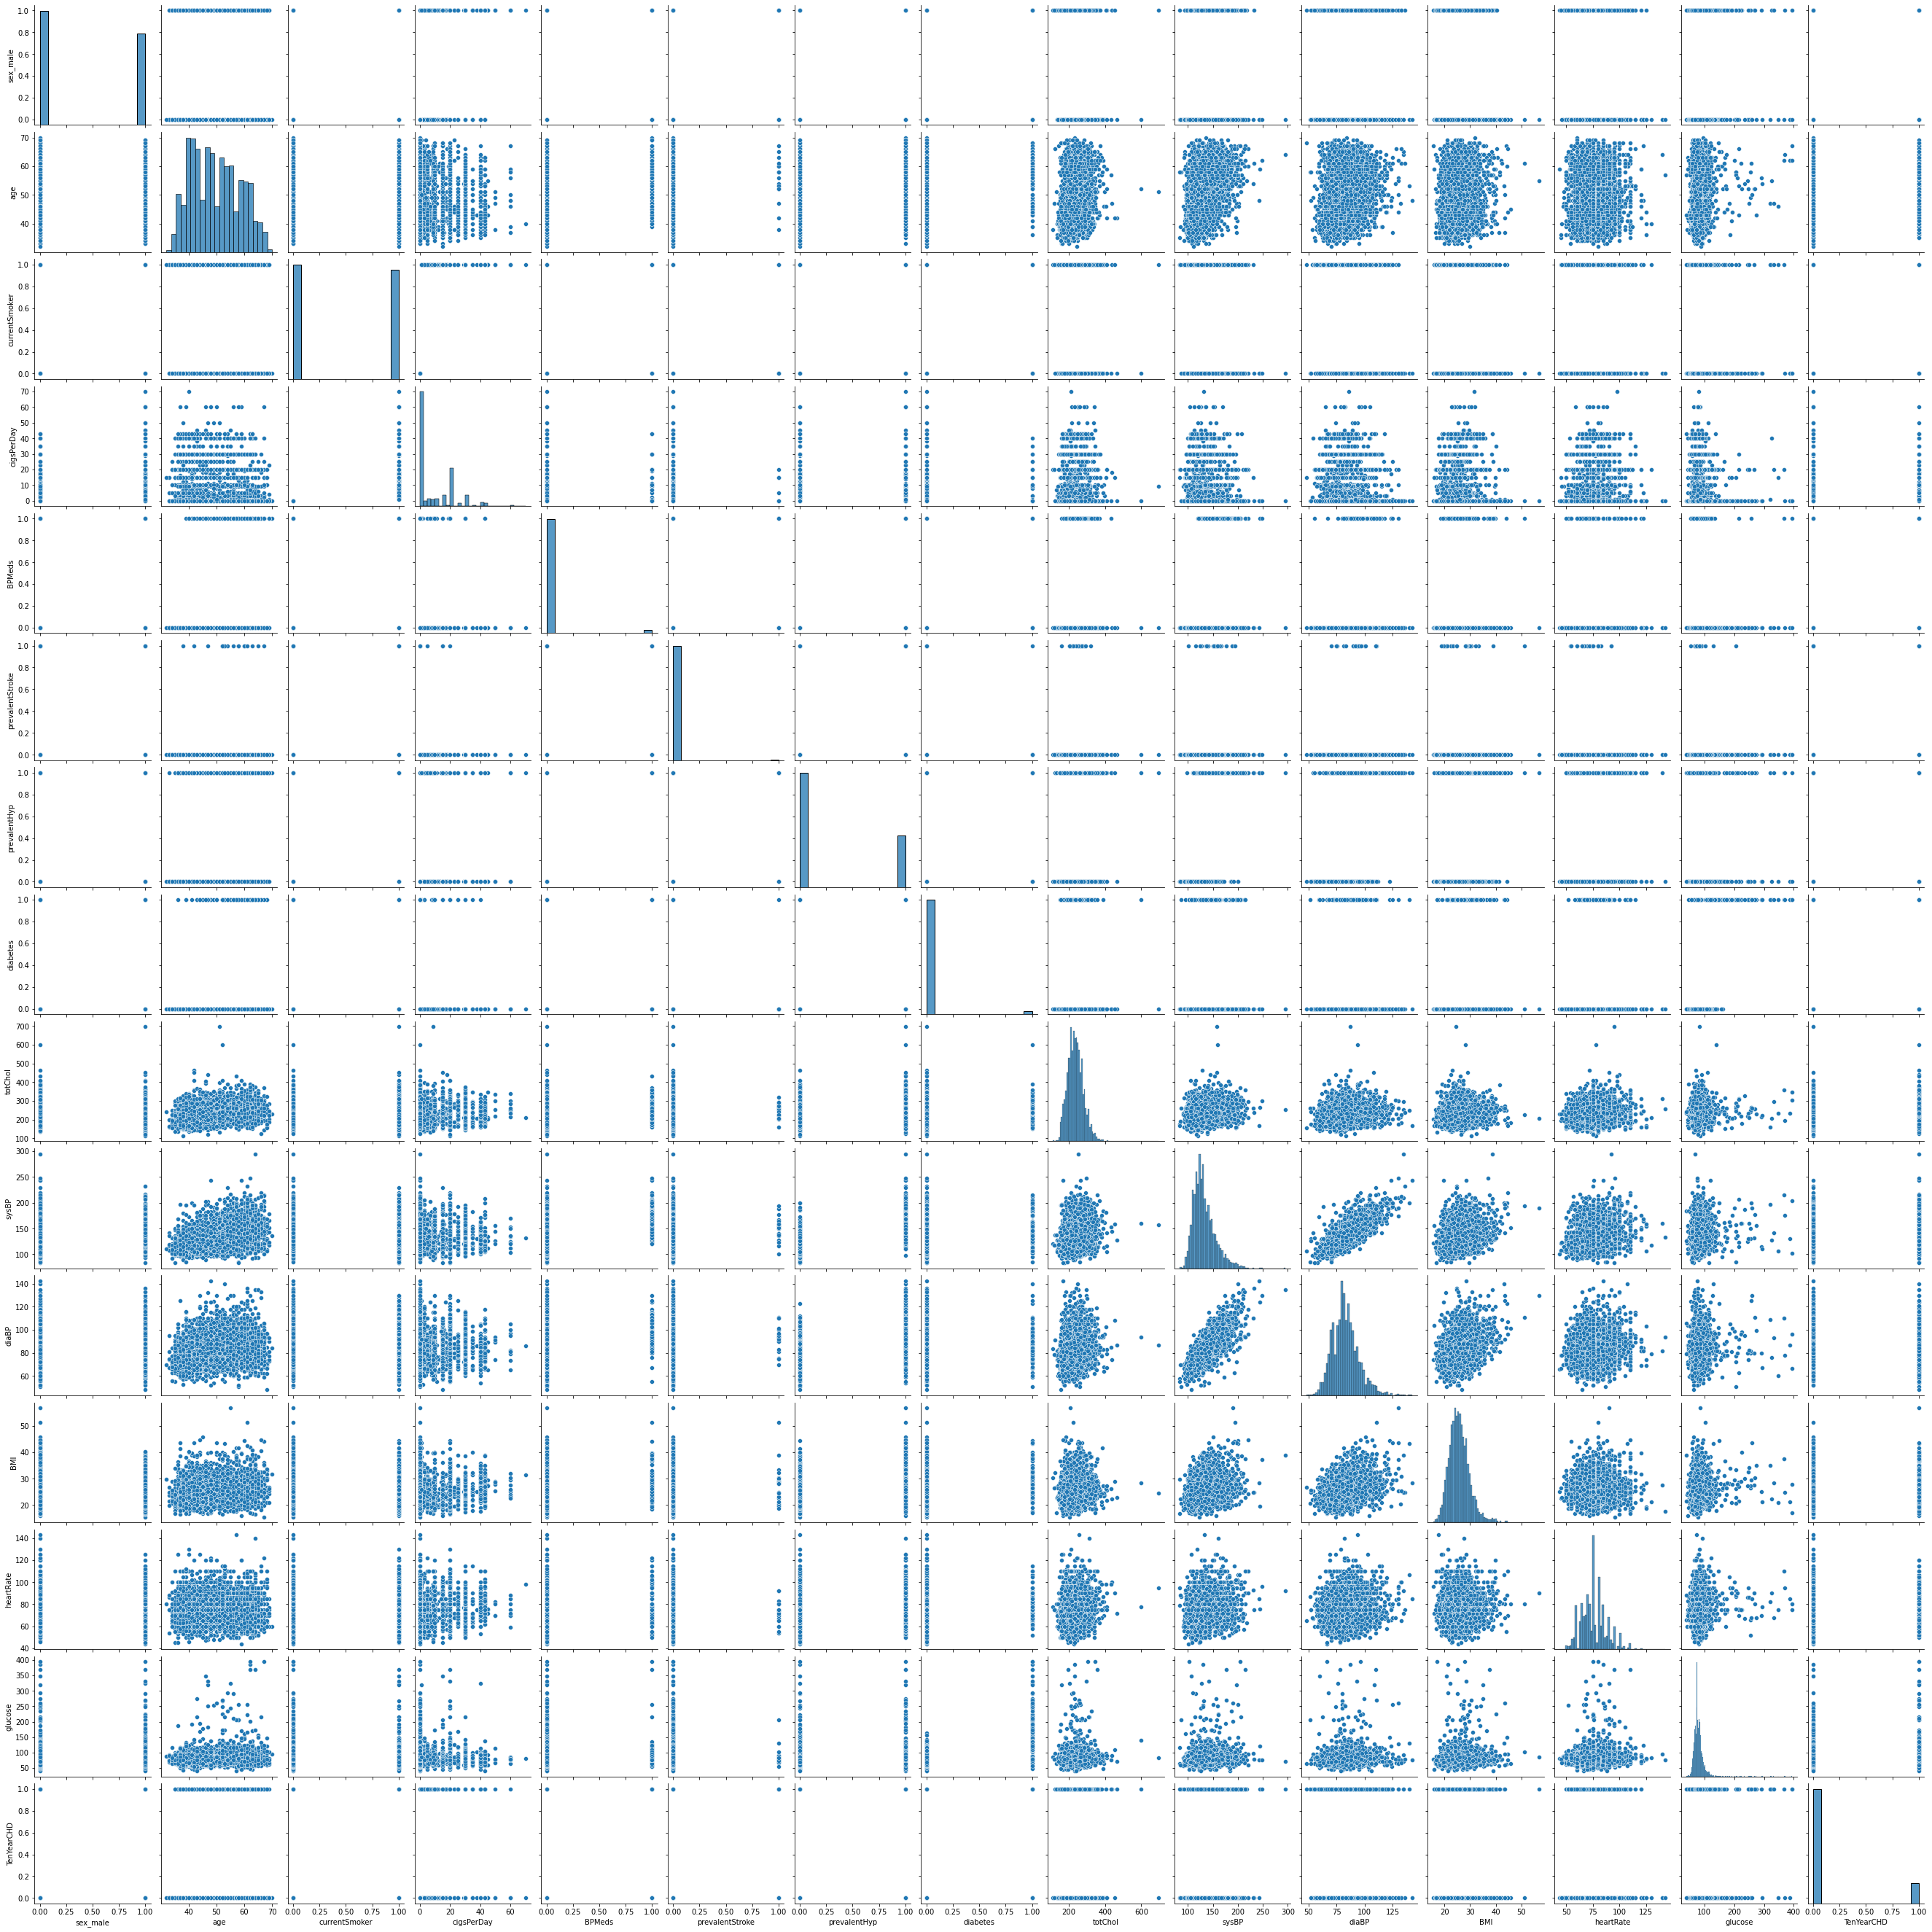

In [41]:
# Plot graphs for all feature data in the dataframe
sn.pairplot(data=chd_df)

In [42]:
#Description of the all feature data in the dataframe
#count - no of non-empty values
#mean - average (mean) value
#std - standard deviation
#min - minimum value
#25% - 25% percentile
#50% - 50% percentile
#75% - 75% percentile
#max - maximum value
chd_df.describe()

,sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000
mean,0.445185,49.578821,0.488397,9.005335,0.030408,0.005601,0.311816,0.027207,236.952787,132.365964,82.933716,25.809651,75.703921,81.883169,0.152574
std,0.497053,8.569322,0.499932,11.922440,0.171730,0.074643,0.463297,0.162709,44.610417,22.051951,11.933321,4.065894,11.957763,23.888039,0.359624
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.090000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


c:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

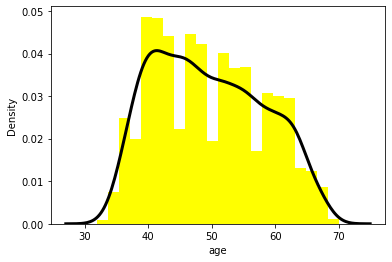

In [43]:
sn.distplot(chd_df['age'],color='Yellow',hist_kws={'alpha':1,"linewidth": 2}, kde_kws={"color": "k", "lw": 3, "label": "KDE"})
#most of people are form age 40-50 
#Gamitha

Text(0.5, 1.0, 'Heart Rate vs Heart Disease')

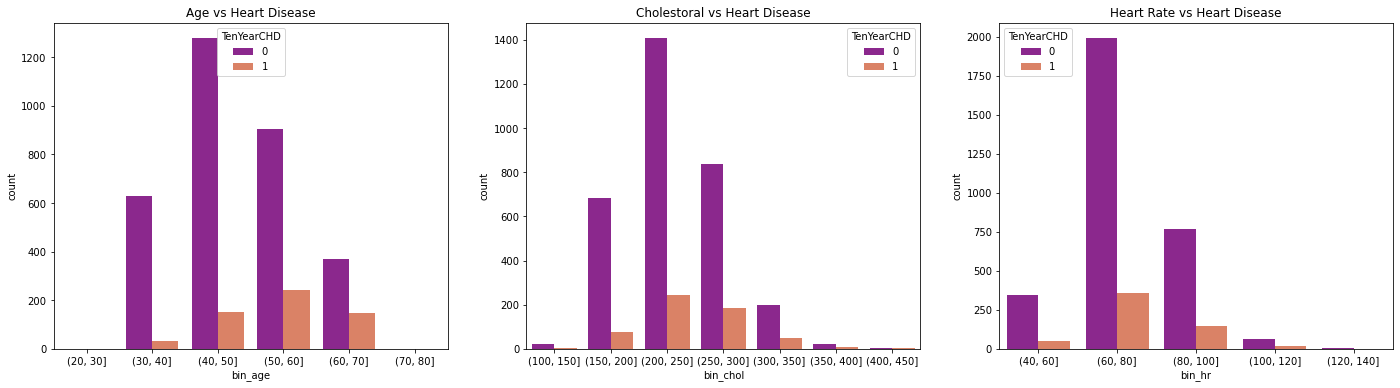

In [44]:
#Gamitha
fig,ax=plt.subplots(figsize=(24,6))

plt.subplot(1, 3, 1)
age_bins = [20,30,40,50,60,70,80]
chd_df['bin_age']=pd.cut(chd_df['age'], bins=age_bins)
g1=sn.countplot(x='bin_age',data=chd_df ,hue='TenYearCHD',palette='plasma',linewidth=3)
g1.set_title("Age vs Heart Disease")
#The number of people with heart disease are more from the age 41-55
#Also most of the people fear heart disease and go for a checkup from age 55-65 and dont have heart disease (Precautions)

plt.subplot(1, 3, 2)
chol_bins = [100,150,200,250,300,350,400,450]
chd_df['bin_chol']=pd.cut(chd_df['totChol'], bins=chol_bins)
g2=sn.countplot(x='bin_chol',data=chd_df,hue='TenYearCHD',palette='plasma',linewidth=3)
g2.set_title("Cholestoral vs Heart Disease")
#Most people get the heart disease with 200-250 cholestrol 
#The others with cholestrol of above 250 tend to think they have heart disease but the rate of heart disease falls

plt.subplot(1, 3, 3)
hr_bins = [40,60,80,100,120,140]
chd_df['bin_hr']=pd.cut(chd_df['heartRate'], bins=hr_bins)
g3=sn.countplot(x='bin_hr',data=chd_df,hue='TenYearCHD',palette='plasma',linewidth=3)
g3.set_title("Heart Rate vs Heart Disease")
#People who have thalach between 140-180 have a very high chance of getting the heart disease 

Text(0.5, 1.0, 'Average Number of Cigarettes Smoked Per Day vs Heart Disease')

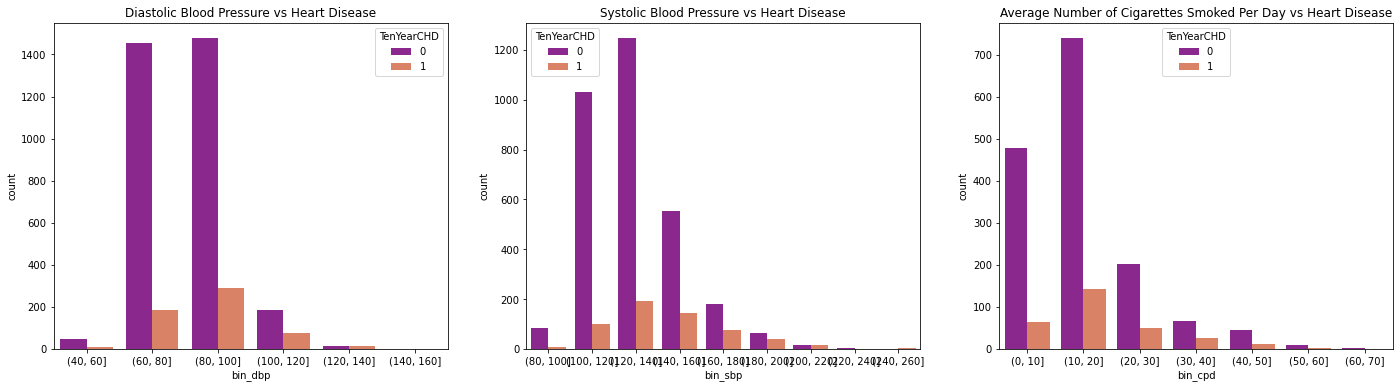

In [45]:
#Sanduni
fig,ax=plt.subplots(figsize=(24,6))

plt.subplot(1, 3, 1)
dbp_bins = [40,60,80,100,120,140,160]
chd_df['bin_dbp']=pd.cut(chd_df['diaBP'], bins=dbp_bins)
g1=sn.countplot(x='bin_dbp',data=chd_df ,hue='TenYearCHD',palette='plasma',linewidth=3)
g1.set_title("Diastolic Blood Pressure vs Heart Disease")
#People who have Continuous Diastolic Blood Pressure level from 60-100 have a very high chance of getting the heart disease.

plt.subplot(1, 3, 2)
sbp_bins = [80,100,120,140,160,180,200,220,240,260]
chd_df['bin_sbp']=pd.cut(chd_df['sysBP'], bins=sbp_bins)
g1=sn.countplot(x='bin_sbp',data=chd_df ,hue='TenYearCHD',palette='plasma',linewidth=3)
g1.set_title("Systolic Blood Pressure vs Heart Disease")
#People who have Continuous Systolic Blood Pressure level from 100-140 have a very high chance of getting the heart disease.

plt.subplot(1, 3, 3)
cpd_bins = [0,10,20,30,40,50,60,70]
chd_df['bin_cpd']=pd.cut(chd_df['cigsPerDay'], bins=cpd_bins)
g1=sn.countplot(x='bin_cpd',data=chd_df ,hue='TenYearCHD',palette='plasma',linewidth=3)
g1.set_title("Average Number of Cigarettes Smoked Per Day vs Heart Disease")
#People who smokes 0-20 no of cigarettes per day ave a very high chance of getting the heart disease.

Text(0.5, 1.0, 'BMI vs Heart Disease')

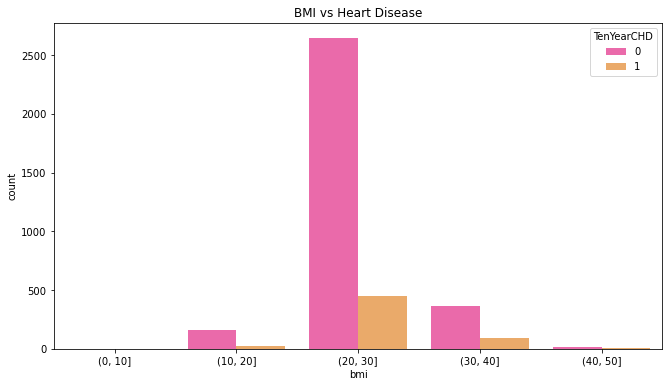

In [46]:
#Gamitha
fig,ax=plt.subplots(figsize=(24,6))

plt.subplot(1, 2, 1)
bmi_bins = [0,10,20,30,40,50]
chd_df['bmi']=pd.cut(chd_df['BMI'], bins=bmi_bins)
x1=sn.countplot(x='bmi',data=chd_df,hue='TenYearCHD',palette='spring',linewidth=3)
x1.set_title('BMI vs Heart Disease')
#People with BMI value between 20-30 have highest chance of heart disease

In [47]:
# IT19138732 - Logistic Regression

Text(0.5, 1.0, 'Age vs Systolic Blood Pressure')

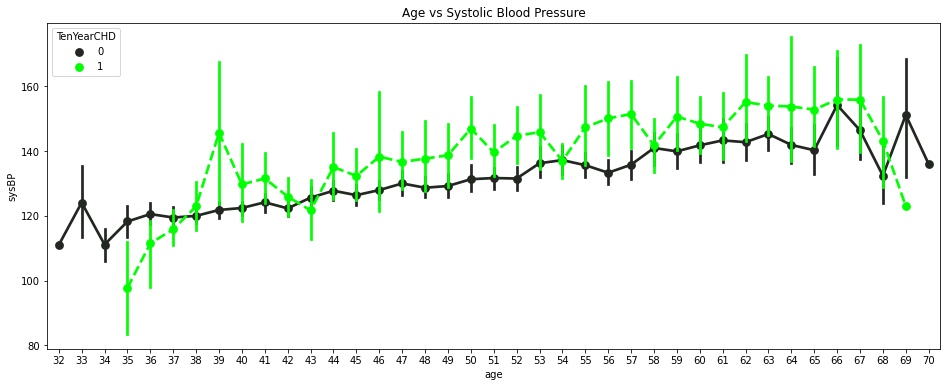

In [48]:
#Danuka
fig,ax=plt.subplots(figsize=(16,6))
sn.pointplot(x='age',y='sysBP',data=chd_df,color='Lime',hue='TenYearCHD',linestyles=["-", "--"])
plt.title('Age vs Systolic Blood Pressure')
#People with heart disease tend to have higher

Text(0.5, 1.0, 'Age vs Continuous Heart Rate')

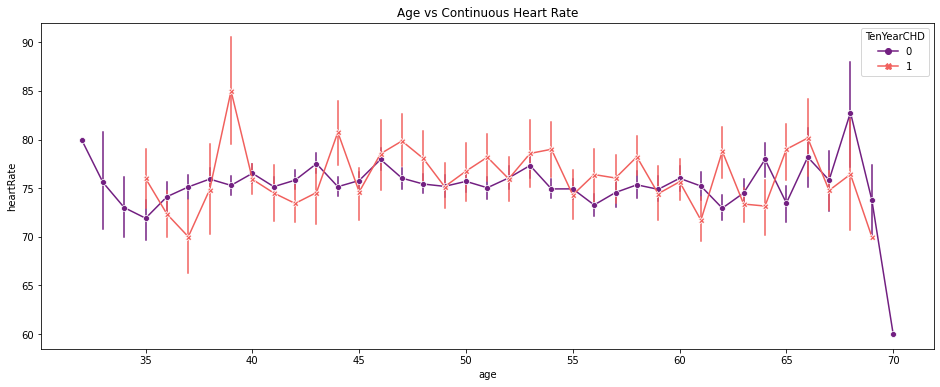

In [49]:
#Danuka
fig,ax=plt.subplots(figsize=(16,6))
sn.lineplot(y='heartRate',x='age',data=chd_df,hue="TenYearCHD",style='TenYearCHD',palette='magma',markers=True, dashes=False,err_style="bars", ci=68)
plt.title('Age vs Continuous Heart Rate')

In [66]:
chd_df.dropna(axis=0,inplace=True)

In [67]:
from statsmodels.tools import add_constant as add_constant
heart_details_constant = add_constant(chd_df)
heart_details_constant.head()

,const,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [65]:
from sklearn.linear_model import LogisticRegression


In [68]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
col=heart_details_constant.columns[:-1]
hd_model=sm.Logit(chd_df.TenYearCHD,heart_details_constant[col])
lr_result=hd_model.fit()
lr_result.summary()

Optimization terminated successfully.
         Current function value: 0.377199
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3749
Model:                          Logit   Df Residuals:                     3734
Method:                           MLE   Df Model:                           14
Date:                Sun, 29 May 2022   Pseudo R-squ.:                  0.1169
Time:                        13:08:14   Log-Likelihood:                -1414.1
converged:                       True   LL-Null:                       -1601.4
Covariance Type:            nonrobust   LLR p-value:                 2.922e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.6463      0.687    -12.577      0.000      -9.994      -7.299
male                0.5740      0.107      5.343      0.000       0.363       0.785
age                 0.0640      0.007      9.787      0.000       0.051       0.077
currentSmoker       0.0732      0.155      0.473      0.636      -0.230       0.376
cigsPerDay          0.0184      0.006      3.003      0.003       0.006       0.030
BPMeds              0.1446      0.232      0.622      0.534      -0.311       0.600
prevalentStroke     0.7191      0.489      1.471      0.141      -0.239       1.677
prevalentHyp        0.2146      0.136      1.574      0.116      -0.053       0.482
diabetes            0.0025      0.312      0.008      0.994      -0.609       0.614
totChol             0.0022      0.001      2.074      0.038       0.000       0.004
sysBP               0.0153      0.004      4.080      0.000       0.008       0.023
diaBP              -0.0039      0.006     -0.619      0.536      -0.016       0.009
BMI                 0.0103      0.013      0.820      0.412      -0.014       0.035
heartRate          -0.0023      0.004     -0.550      0.583      -0.010       0.006
glucose             0.0076      0.002      3.408      0.001       0.003       0.012
===================================================================================
"""

In [69]:
def backward_elemination (hd_frame,dependent_var,column_list):
    while len(column_list)>0 :
        model=sm.Logit(dependent_var,hd_frame[column_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            column_list=column_list.drop(largest_pvalue.index)

result=backward_elemination(heart_details_constant,chd_df.TenYearCHD,col)

In [70]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3749
Model:                          Logit   Df Residuals:                     3742
Method:                           MLE   Df Model:                            6
Date:                Sun, 29 May 2022   Pseudo R-squ.:                  0.1148
Time:                        13:08:28   Log-Likelihood:                -1417.6
converged:                       True   LL-Null:                       -1601.4
Covariance Type:            nonrobust   LLR p-value:                 2.548e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1211      0.468    -19.491      0.000     -10.038      -8.204
male           0.5813      0.105      5.521      0.000       0.375       0.788
age            0.0654      0.006     10.330      0.000       0.053       0.078
cigsPerDay     0.0197      0.004      4.803      0.000       0.012       0.028
totChol        0.0023      0.001      2.099      0.036       0.000       0.004
sysBP          0.0174      0.002      8.166      0.000       0.013       0.022
glucose        0.0076      0.002      4.573      0.000       0.004       0.011
==============================================================================
"""

In [71]:
hd_params = np.exp(result.params)
conf_intervals = np.exp(result.conf_int())
conf_intervals['OR'] = hd_params
pvalue=round(result.pvalues,3)
conf_intervals['pvalue']=pvalue
conf_intervals.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf_intervals))

            CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const           0.000044       0.000274    0.000109   0.000
male            1.454877       2.198166    1.788313   0.000
age             1.054409       1.080897    1.067571   0.000
cigsPerDay      1.011730       1.028128    1.019896   0.000
totChol         1.000150       1.004386    1.002266   0.036
sysBP           1.013299       1.021791    1.017536   0.000
glucose         1.004343       1.010895    1.007614   0.000


In [73]:
import sklearn
new_hd_features=chd_df[['age','male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x=new_hd_features.iloc[:,:-1]
y=new_hd_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)
print(x_train,x_test,y_train,y_test)

      age  male  cigsPerDay  totChol  sysBP  glucose
1820   55     0         5.0    280.0  144.0     75.0
2979   45     0         0.0    258.0  148.5     90.0
3247   51     1        40.0    212.0  122.5     74.0
1191   60     1        20.0    260.0  178.0     79.0
146    59     0         1.0    259.0  141.0     86.0
...   ...   ...         ...      ...    ...      ...
3612   49     0         0.0    308.0  128.0     70.0
3452   42     0         9.0    195.0  126.0     77.0
1944   39     0         0.0    220.0  137.5     88.0
2549   64     0         0.0    266.0  166.0     87.0
3306   56     1         0.0    193.0  114.0     88.0

[2999 rows x 6 columns]       age  male  cigsPerDay  totChol  sysBP  glucose
3886   65     1         0.0    205.0  106.0     87.0
3026   66     0         0.0    273.0  197.0     80.0
4045   56     1         0.0    177.0  124.0     88.0
2923   43     1        30.0    252.0  112.0     65.0
2167   42     0        30.0    240.0  127.0     69.0
...   ...   ...      

In [74]:
from sklearn.linear_model import LogisticRegression
logistic_reg=LogisticRegression()
logistic_reg.fit(x_train,y_train)
y_prediction=logistic_reg.predict(x_test)
print(y_prediction)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

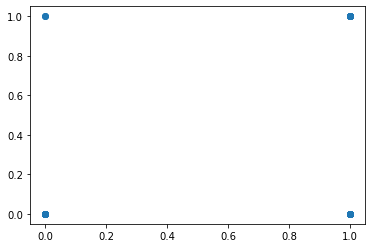

In [75]:
plt.scatter(y_test, y_prediction)

(array([  2.,   0.,   0.,   0.,   0., 653.,   0.,   0.,   0.,  95.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

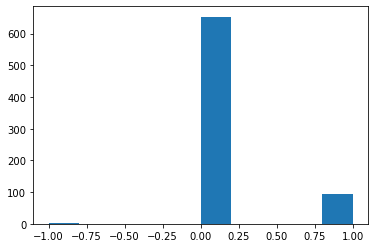

In [76]:
plt.hist(y_test - y_prediction)